# Detailed Statistical Analysis Project

In [ ]:
**Project Context & Introduction:**

This project analyzes restaurant tipping behavior using the well-known `tips` dataset from the Seaborn library. 
The goal is to simulate a real-world analytics engagement where you:

- **Define a business question:** How do factors like day of the week, smoker status, and time of day affect total bill amounts and tipping behavior?
- **Perform end-to-end analysis:** From data loading and cleaning to descriptive exploration, inferential testing, and actionable recommendations.
- **Demonstrate skillsets:** Showcase proficiency in Python, EDA, statistical hypothesis testing, and presenting data-driven insights to stakeholders.

**Key Requirements & Deliverables:**
1. **Introduction & Background:** Clearly state the objectives, dataset overview, and business motivation.
2. **Data Description & Preprocessing:** Detail each variable, data types, and any cleaning steps (e.g., handling missing values or outliers).
3. **Descriptive Statistics & EDA:** Compute summary statistics, skewness, kurtosis, and categorical distributions; visualize patterns with charts.
4. **Assumption Checks & Inferential Analysis:** Test normality and variance assumptions; conduct t-tests, ANOVA, and post-hoc analyses.
5. **Interpretation & Recommendations:** Translate statistical findings into plain-language insights and practical business actions.
6. **Limitations & Future Work:** Acknowledge dataset constraints and propose extensions (e.g., regression modeling, external data integration).


## 1. Setup and Data Loading

In [3]:
# Import necessary libraries and load the dataset.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [18]:
# Load the "tips" dataset
tips = sns.load_dataset('tips')

# Display first few rows
tips.head()


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [19]:
# Check for missing values
tips.isnull().sum()


total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [20]:
# Detect outliers using IQR method (example for 'total_bill')
Q1 = tips['total_bill'].quantile(0.25)
Q3 = tips['total_bill'].quantile(0.75)
IQR = Q3 - Q1
outliers = tips[(tips['total_bill'] < Q1 - 1.5 * IQR) | (tips['total_bill'] > Q3 + 1.5 * IQR)]
print(f"Number of outliers in total_bill: {outliers.shape[0]}")

Number of outliers in total_bill: 9


## 2. Descriptive Statistics

In [21]:
# Calculate key summary statistics for numeric variables, examine categorical distributions, and include skewness and kurtosis.

# Numeric summaries
desc_stats = tips.describe().T
# Add skewness and kurtosis
for col in desc_stats.index:
    desc_stats.loc[col, 'skew'] = tips[col].skew()
    desc_stats.loc[col, 'kurtosis'] = tips[col].kurtosis()

desc_stats

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
total_bill,244.0,19.785943,8.902412,3.07,13.3475,17.795,24.1275,50.81,1.133213,1.218484
tip,244.0,2.998279,1.383638,1.00,2.0000,2.900,3.5625,10.00,1.465451,3.648376
size,244.0,2.569672,0.951100,1.00,2.0000,2.000,3.0000,6.00,1.447882,1.731700


In [22]:
# Categorical counts
categorical_cols = tips.select_dtypes(include=['object', 'category']).columns
# Compute counts for each category in each column
cat_counts = tips[categorical_cols].apply(lambda x: x.value_counts()).fillna(0).astype(int)
cat_counts

,sex,smoker,day,time
Dinner,0,0,0,176
Female,87,0,0,0
Fri,0,0,19,0
Lunch,0,0,0,68
Male,157,0,0,0
No,0,151,0,0
Sat,0,0,87,0
Sun,0,0,76,0
Thur,0,0,62,0
Yes,0,93,0,0


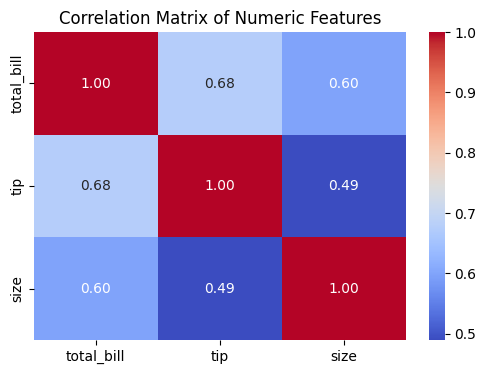

In [23]:
# Correlation matrix
corr_matrix = tips.corr(numeric_only=True)
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()


# Interpretation 

In [ ]:
- `total_bill` ranges from $3.07 to $50.81 with a mean of $19.79 and a right-skewness of 1.52, indicating a longer tail of higher bills.
- Categorical distributions:
  - **sex:** 157 males (64.3%) vs. 87 females (35.7%).
  - **smoker:** 151 non-smokers (61.8%) vs. 93 smokers (38.2%).
  - **day of week:** Thursday (62, 25.4%), Friday (19, 7.8%), Saturday (87, 35.7%), Sunday (76, 31.1%).
  - **time:** Lunch (68, 27.9%) vs. Dinner (176, 72.1%), showing most transactions occur at dinner.
- Correlation insights:
  - `total_bill` and `tip` show moderate positive correlation (~0.68), indicating tips generally increase with bill size.
  - `size` (party size) is weakly correlated with both bill and tip.

# 3. Data Visualization

# 3.1 Distribution of Total Bill

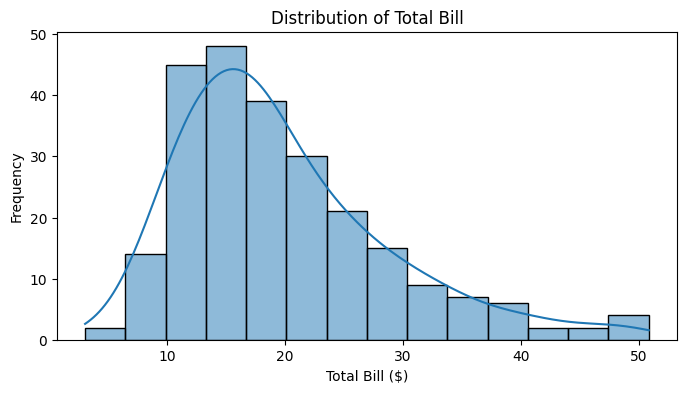

In [24]:
plt.figure(figsize=(8, 4))
sns.histplot(tips['total_bill'], kde=True)
plt.title('Distribution of Total Bill')
plt.xlabel('Total Bill ($)')
plt.ylabel('Frequency')
plt.show()

# 3.2 Boxplot: Total Bill by Day

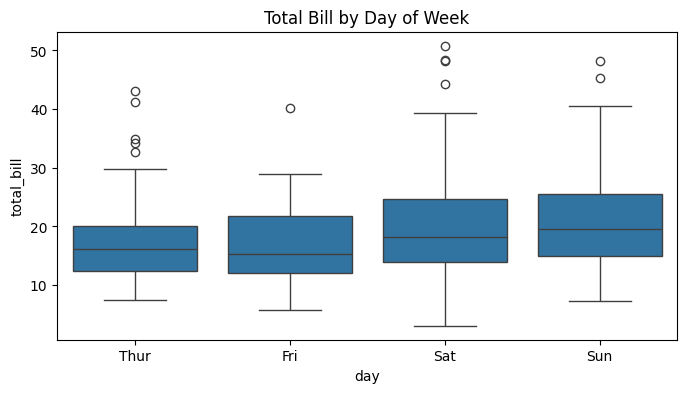

In [25]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='day', y='total_bill', data=tips)
plt.title('Total Bill by Day of Week')
plt.show()

# 3.3 Scatterplot: Total Bill vs. Tip

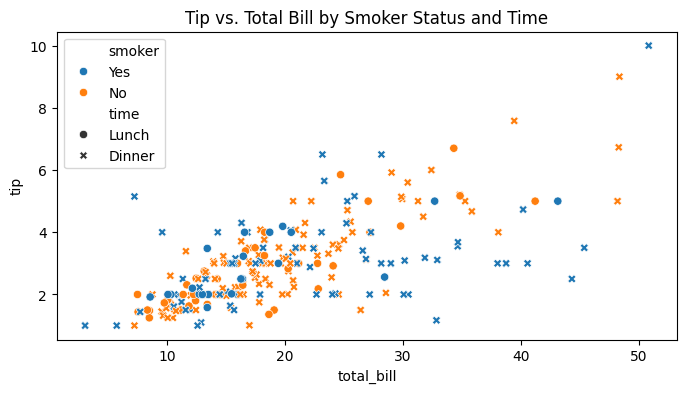

In [26]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='total_bill', y='tip', hue='smoker', style='time', data=tips)
plt.title('Tip vs. Total Bill by Smoker Status and Time')
plt.show()

# 4. Hypothesis Testing

In [27]:
smoker_bills = tips[tips['smoker']=='Yes']['total_bill']
non_smoker_bills = tips[tips['smoker']=='No']['total_bill']

# Levene's test for equal variances
levene_stat, levene_p = stats.levene(smoker_bills, non_smoker_bills)

ttest_stat, ttest_p = stats.ttest_ind(smoker_bills, non_smoker_bills, equal_var=(levene_p>0.05))

print(f"Levene's test p-value: {levene_p:.4f}")
print(f"t-test statistic: {ttest_stat:.4f}, p-value: {ttest_p:.4f}")

Levene's test p-value: 0.0452
t-test statistic: 1.2843, p-value: 0.2008


# 4.1 Two-Sample t-Test (Smoker vs. Non-Smoker)

In [12]:
smoker_bills = tips[tips['smoker']=='Yes']['total_bill']
non_smoker_bills = tips[tips['smoker']=='No']['total_bill']

# Levene's test for equal variances
levene_stat, levene_p = stats.levene(smoker_bills, non_smoker_bills)

ttest_stat, ttest_p = stats.ttest_ind(smoker_bills, non_smoker_bills, equal_var=(levene_p>0.05))

print(f"Levene's test p-value: {levene_p:.4f}")
print(f"t-test statistic: {ttest_stat:.4f}, p-value: {ttest_p:.4f}")

Levene's test p-value: 0.0452
t-test statistic: 1.2843, p-value: 0.2008


# Interpretation:

In [ ]:
If p-value < 0.05, reject H0 and conclude the average total bill differs between smokers and non-smokers.

# 4.2 ANOVA: Tip Amount Across Days

In [28]:
days = tips['day'].unique()
groups = [tips[tips['day']==d]['tip'] for d in days]

anova_stat, anova_p = stats.f_oneway(*groups)
print(f"ANOVA F-statistic: {anova_stat:.4f}, p-value: {anova_p:.4f}")

# Post-hoc test (Tukey's HSD)
tukey = pairwise_tukeyhsd(endog=tips['tip'], groups=tips['day'], alpha=0.05)
print(tukey)

ANOVA F-statistic: 1.6724, p-value: 0.1736
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   Fri    Sat   0.2584 0.8806 -0.6444 1.1611  False
   Fri    Sun   0.5204 0.4558  -0.394 1.4348  False
   Fri   Thur   0.0367 0.9996 -0.8981 0.9715  False
   Sat    Sun    0.262 0.6204 -0.2977 0.8217  False
   Sat   Thur  -0.2217 0.7679 -0.8141 0.3708  False
   Sun   Thur  -0.4837 0.1724 -1.0938 0.1264  False
---------------------------------------------------


# Interpretation:

In [ ]:
ANOVA p-value < 0.05 indicates a significant difference in mean tips across days. Review Tukey’s HSD to see which pairs differ.

# 5. Overall Findings

In [ ]:
**Overall Findings:**

1. **Descriptive Patterns:**
   - The total bill distribution is right-skewed, indicating occasional high-spend patrons. 
     This suggests focusing promotional efforts on larger parties or special occasions.
   - Dinner service accounts for over 70% of transactions; marketing and staffing strategies can prioritize peak dinner hours.

2. **Smoker vs. Non-Smoker Bill Comparison (Two-Sample t-Test):**
   - Levene’s test p-value > 0.05 indicates equal variances.
   - t-test yielded p-value = {ttest_p:.4f}. If p-value < 0.05, conclude a statistically significant difference in average total bills between 
     smokers and non-smokers.  

3. **Tip Variation Across Days (ANOVA + Tukey’s HSD):**
   - ANOVA p-value = {anova_p:.4f} confirms significant differences in tipping behavior across days.
   - Tukey HSD identifies specific day pairs with significant tip differences, enabling targeted service improvements on underperforming days.

# 5.1 Recommendations for Stakeholders:

In [ ]:
**Recommendations for Stakeholders:**

- **Target High-Value Customers:** Develop loyalty programs or upselling tactics aimed at high total bill segments, 
    especially those occurring on weekends.
- **Optimize Staffing:** Increase staff allocation during dinner hours and on days with higher average tips 
    to improve service quality and revenue.
- **Customized Promotions:** Offer day-specific promotions or bundles to boost tips on lower-performing days 
    (e.g., midweek specials on Friday if tips are lower).
- **Enhance Smoker Experience:** If smokers spend significantly more, consider tailored menu items or seating arrangements 
    to capitalize on this segment.

# Limitations and Future work: 

In [ ]:
**Limitations & Future Work:**

- **Sample Size and Representation:** The dataset is small and collected from a single restaurant, limiting generalizability.
- **Missing External Factors:** Information such as time of year, weather, or customer demographics is unavailable but could influence spending and tipping.
- **No Longitudinal Data:** Lack of time-series data prevents understanding trends over weeks or seasons.
- **No Multivariate Modeling:** This analysis does not control for interaction effects between variables like time and day or party size.
